# Cohort and RFM Analysis
on the dataset of all purchases made from an online retail company based in the UK during an eight-month period.


In [55]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [56]:
# Load the data
sales = pd.read_csv('/home/salohuddin/Desktop/pandas/OnlineRetail.csv', encoding='ISO-8859-1')
sales.shape

(541909, 8)

In [57]:
# Set max number of rows to display
pd.set_option('display.max_rows', 150)

# Data Cleaning

1. Null values

In [58]:
# Identify columns with null values
sales.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [59]:
# Because our analysis requires the customer be identified, NaN CustomerID values are not relevant for us, hence they can be dropped 
sales = sales[sales['CustomerID'].notna()]

In [60]:
sales.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Dropping CustomerID NaN values has also made Description null values go away, which means they were probably related.

2. Check for duplicates

In [61]:
sales[sales.duplicated()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.00,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.00,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.00,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.00,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,12/1/2010 11:49,2.95,17920.00,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.00,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.00,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.00,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.00,United Kingdom


There are 5225 duplicate entries. We are going to drop them.

In [62]:
sales.drop_duplicates(inplace=True)

In [63]:
# There are negative Quantity values
sales[sales['Quantity'] < 0]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.00,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.00,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.00,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.00,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.00,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.00,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.00,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.00,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.00,United Kingdom


In [64]:
# Some invoices start with C. Need to check if there are other cases as well
sales['InvoiceNo'].str[0].unique()

array(['5', 'C'], dtype=object)

Invoice number starts with either 'C' or '5'. Need to find out when it starts with 'C' and it starts with 5.

In [65]:
sales[sales['Quantity'] > 0]['InvoiceNo'].str[0].unique()

array(['5'], dtype=object)

In [66]:
sales[sales['Quantity'] < 0]['InvoiceNo'].str[0].unique()

array(['C'], dtype=object)

Only when the Quantity is a negative value, does InvoiceNo start with 'C', which probably stands for 'Cancelled'. Assuming that's true, Cancelled orders are not relevant for our analysis. So, we can drop them

In [67]:
sales = sales[sales['Quantity'] > 0]

3. Separate InvoiceDate into Date and Time columns

In [68]:
sales['InvoiceDate'].describe()

count               392732
unique               17286
top       11/14/2011 15:27
freq                   542
Name: InvoiceDate, dtype: object

In [69]:
sales['InvoiceTime'] = sales['InvoiceDate'].str.extract(' (.+)$')

In [70]:
sales['InvoiceDate'] = sales['InvoiceDate'].str.extract('^(.+) ')

In [71]:
# Convert InvoiceDate to pandas datetime format
sales['InvoiceDate'] = pd.to_datetime(sales['InvoiceDate'])

In [72]:
# Convert CustomerID to string and remove trailing '.0'
sales['CustomerID'] = sales['CustomerID'].astype(str)

In [73]:
sales['CustomerID'].str[6:].unique()

array(['0'], dtype=object)

In [74]:
sales['CustomerID'] = sales['CustomerID'].str[:5]

In [75]:
# Some values in 'Country' coulumn contain 'Unspecified'
sales[sales['Country'] == 'Unspecified']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceTime
152712,549687,20685,DOORMAT RED RETROSPOT,2,2011-04-11,7.95,12363,Unspecified,13:29
152713,549687,22691,DOORMAT WELCOME SUNRISE,2,2011-04-11,7.95,12363,Unspecified,13:29
152714,549687,48116,DOORMAT MULTICOLOUR STRIPE,2,2011-04-11,7.95,12363,Unspecified,13:29
152715,549687,21213,PACK OF 72 SKULL CAKE CASES,24,2011-04-11,0.55,12363,Unspecified,13:29
152716,549687,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,2011-04-11,0.55,12363,Unspecified,13:29
...,...,...,...,...,...,...,...,...,...
308810,564051,23007,SPACEBOY BABY GIFT SET,1,2011-08-22,16.95,14265,Unspecified,13:32
308811,564051,21833,CAMOUFLAGE LED TORCH,12,2011-08-22,1.69,14265,Unspecified,13:32
308812,564051,23081,GREEN METAL BOX ARMY SUPPLIES,2,2011-08-22,8.25,14265,Unspecified,13:32
308813,564051,23046,PAPER LANTERN 9 POINT DELUXE STAR,2,2011-08-22,6.65,14265,Unspecified,13:32


In [76]:
# Dropping rows with 'Unspecified' Country value
sales.drop(sales[sales['Country'] == 'Unspecified'].index, inplace=True)

# Cohort Analysis
    1. Create cohorts

In [77]:
# Create FirstOrderDate column
sales = pd.merge(sales, sales.groupby('CustomerID')['InvoiceDate'].min().reset_index().set_index('CustomerID').rename(
    columns={'InvoiceDate': 'FirstOrderDate'}), on='CustomerID')

In [46]:
# Creating cohort month column
sales['Cohort'] = sales['FirstOrderDate'].dt.to_period('M')

In [32]:
# Creating cohort_index (difference betweeen the first and the subsequent purchase) column
sales['cohort_index'] = (sales['InvoiceDate'].dt.to_period('M') - sales['FirstOrderDate'].dt.to_period('M')).apply(lambda x: x.n)

In [52]:
sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceTime,FirstOrderDate,cohort_month,cohort_index
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,8:26,2010-12-01,2010-12,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,8:26,2010-12-01,2010-12,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,8:26,2010-12-01,2010-12,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,8:26,2010-12-01,2010-12,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,8:26,2010-12-01,2010-12,0


In [47]:
# Creating retention table
cohort_retention = pd.pivot_table(sales, values='CustomerID', index=['Cohort'], columns='cohort_index', aggfunc='nunique')
cohort_retention = cohort_retention.divide(cohort_retention.iloc[:,0], axis=0).map(lambda x: round(x*100, 2))
cohort_retention

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12
Cohort,,,,,,,,,,,,,
2010-12,100.00,38.19,33.44,38.71,35.97,39.66,37.97,35.44,35.44,39.45,37.34,50.00,27.43
2011-01,100.00,23.99,28.27,24.23,32.78,29.93,26.13,25.65,31.12,34.68,36.82,14.96,NaN
2011-02,100.00,24.74,19.21,27.89,26.84,24.74,25.53,28.16,25.79,31.32,9.21,NaN,NaN
2011-03,100.00,19.09,25.45,21.82,23.18,17.73,26.36,23.86,28.86,8.86,NaN,NaN,NaN
2011-04,100.00,22.74,22.07,21.07,20.74,23.75,23.08,26.09,8.36,NaN,NaN,NaN,NaN
2011-05,100.00,23.66,17.20,17.20,21.51,24.37,26.52,10.39,NaN,NaN,NaN,NaN,NaN
2011-06,100.00,20.85,18.72,27.23,24.68,33.62,10.21,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,100.00,20.94,20.42,23.04,27.23,11.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,100.00,25.15,25.15,25.15,13.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='cohort_index', ylabel='Cohort'>

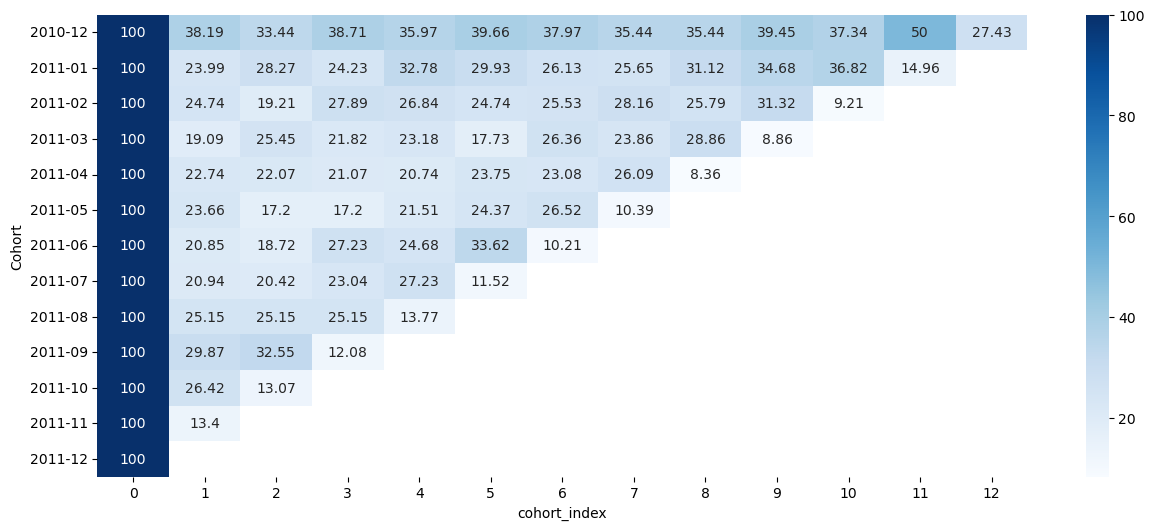

In [78]:
# cohort_retention.index = cohort_retention.index.strftime('%B %Y')
plt.figure(figsize=(15, 6))
sns.heatmap(cohort_retention, annot=True, cmap='Blues', fmt='g')


# RFM Analysis

In [80]:
# Creating TotalPrice for calculating total spending on a single order
sales['TotalPrice'] = sales['UnitPrice'] * sales['Quantity']


In [82]:
import datetime as dt
# Creating an RFM table
# Assuming analysis is being conducted on 2011-12-10 (day right after the last day in the data)

now =  dt.datetime(2011,12,10)

rfm_table = sales.groupby('CustomerID').agg({
                                'InvoiceDate': lambda dates: (now - dates.max()).days,
                                'InvoiceNo': lambda invoices: len(invoices),
                                'TotalPrice': lambda prices: prices.sum()}).reset_index().set_index('CustomerID')
rfm_table.rename(columns={
                        'InvoiceDate': 'Recency',
                        'InvoiceNo': 'Frequency',
                        'TotalPrice': 'Monetary'}, inplace=True)
rfm_table


,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,3,182,4310.00
12348,76,31,1797.24
12349,19,73,1757.55
12350,311,17,334.40
...,...,...,...
18280,278,10,180.60
18281,181,7,80.82
18282,8,12,178.05


In [83]:
# Defining quantiles for segmentation
quantiles = rfm_table.quantile(q=[0.20, 0.40, 0.60, 0.80])



# Creating functions to assign R, F, and M segments
def assign_r_score(x, recency_quantiles):
    if x <= recency_quantiles.iloc[0]:
        return 5
    if x <= recency_quantiles.iloc[1]:
        return 4
    elif x <= recency_quantiles.iloc[2]:
        return 3
    elif x <= recency_quantiles.iloc[3]:
        return 2
    else:
        return 1

def assign_f_m_score(x, quantiles):
    if x <= quantiles.iloc[0]:
        return 1
    if x <= quantiles.iloc[1]:
        return 2
    elif x <= quantiles.iloc[2]:
        return 3
    elif x <= quantiles.iloc[3]:
        return 4
    else:
        return 5

# Assigning R, F, and M segments
rfm_table['R_Score'] = rfm_table['Recency'].apply(assign_r_score, args=(quantiles['Recency'],))
rfm_table['F_Score'] = rfm_table['Frequency'].apply(assign_f_m_score, args=(quantiles['Frequency'],))
rfm_table['M_Score'] = rfm_table['Monetary'].apply(assign_f_m_score, args=(quantiles['Monetary'],))

# Combining R, F, and M scores into RFM score
rfm_table['RFM_Score'] = rfm_table['R_Score'].astype(str) + rfm_table['F_Score'].astype(str) + rfm_table['M_Score'].astype(str)



In [84]:
rfm_table

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
CustomerID,,,,,,,
12346,326,1,77183.60,1,1,5,115
12347,3,182,4310.00,5,5,5,555
12348,76,31,1797.24,2,3,4,234
12349,19,73,1757.55,4,4,4,444
12350,311,17,334.40,1,2,2,122
...,...,...,...,...,...,...,...
18280,278,10,180.60,1,1,1,111
18281,181,7,80.82,1,1,1,111
18282,8,12,178.05,5,1,1,511


In [184]:
segment_map = {
    r'[4-5]{3}': 'Champions',
    r'[3-5]{3}': 'Loyal',
    r'[3-5][2-5][1-3]': 'Potential Loyalists',
    r'[3-5][1-2]{2}': 'New Customers',
    r'[3-5][1-2][1-5]': 'Promising',
    r'[3-5][2-4][3-5]': 'Need Attention',
    r'[2-3][1-5][1-3]': 'About To Sleep',
    r'[1-2][1][3-5]|[1-2][4-5][3-5]': 'Cannot Lose Them But Losing',
    r'[1-2][2-5]{2}': 'At Risk',
    r'[1-3][1-3][1-3]': 'Hibernating Customers',
    r'[1][1-5][1-2]': 'Losing But Engaged',
    r'[1][1-5][1-2]': 'Lost Customers'
}


rfm_table['Segment'] = rfm_table['RFM_Score']
rfm_table['Segment'] = rfm_table['Segment'].replace(segment_map, regex=True)

In [187]:
rfm_table

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
CustomerID,,,,,,,,
12346,326,1,77183.60,1,1,5,115,Cannot Lose Them But Losing
12347,3,182,4310.00,5,5,5,555,Champions
12348,76,31,1797.24,2,3,4,234,At Risk
12349,19,73,1757.55,4,4,4,444,Champions
12350,311,17,334.40,1,2,2,122,At Risk
...,...,...,...,...,...,...,...,...
18280,278,10,180.60,1,1,1,111,Hibernating Customers
18281,181,7,80.82,1,1,1,111,Hibernating Customers
18282,8,12,178.05,5,1,1,511,New Customers


In [195]:
rfm_table.reset_index(inplace=True)

In [200]:
rfm_table.groupby('Segment')['CustomerID'].count().sort_values(ascending=False)

Segment
Champions                      918
Loyal                          801
About To Sleep                 605
Potential Loyalists            533
Hibernating Customers          428
At Risk                        413
Cannot Lose Them But Losing    272
New Customers                  265
Promising                       95
Lost Customers                   5
Name: CustomerID, dtype: int64